In [3]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [8]:
# ======================
# Step 1: Mount Google Drive
# ======================
from google.colab import drive
drive.mount('/content/drive')

# ======================
# Step 2: Unzip dataset if not already done
# ======================
import zipfile, os

zip_path = "/content/drive/MyDrive/facial-emotions/archive.zip"
extract_path = "/content/facial_recognition"

if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted")
else:
    print("📂 Dataset already extracted")

# ======================
# Step 3: Imports
# ======================
import timm
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import zipfile, os

# ======================
# Step 4: Data transforms & dataset loading
# ======================
train_dir = os.path.join(extract_path, "train")

# ===== Transform (ViT expects 224x224 RGB) =====
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# ===== Load and split train set into train/val =====
full_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
num_classes = len(full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Use validation transforms for val_dataset
val_dataset.dataset.transform = transform_val

# ======================
# Step 4: Weighted sampler for imbalanced classes
# ======================
# Count class frequencies in train subset
targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_sample_count = np.array([np.sum(np.array(targets) == t) for t in range(num_classes)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in targets])
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

# ======================
# Step 5: DataLoaders
# ======================
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# ===== Create ViT model =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(
    "vit_small_patch16_224",
    pretrained=True,
    num_classes=len(full_train_dataset.classes)
)
model = model.to(device)

# ===== Freeze backbone parameters =====
for name, param in model.named_parameters():
    if "head" not in name:  # keep the head trainable
        param.requires_grad = False

# Now only the head parameters will be updated
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(f"✅ Number of trainable parameters: {sum(p.numel() for p in trainable_params)}")

# Weighted loss
class_weights = torch.tensor(class_sample_count.sum() / class_sample_count, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(trainable_params, lr=1e-3)

# ===== Training Loop =====
epochs = 10
best_val_acc = 0.0

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} "
          f"Val Loss: {val_loss/len(val_loader):.4f} "
          f"Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "vit_fer2013_best.pth")
        print("💾 Saved best model!")

print("✅ Training complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Dataset already extracted


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✅ Number of trainable parameters: 2695
Epoch [1/5] Train Loss: 1.2666 Val Loss: 1.2443 Val Acc: 51.50%
Epoch [2/5] Train Loss: 1.1574 Val Loss: 1.1643 Val Acc: 56.81%
Epoch [3/5] Train Loss: 1.1308 Val Loss: 1.1445 Val Acc: 56.72%
Epoch [4/5] Train Loss: 1.1203 Val Loss: 1.1528 Val Acc: 57.02%
Epoch [5/5] Train Loss: 1.1113 Val Loss: 1.1527 Val Acc: 57.28%


Test Loss: 1.1435
              precision    recall  f1-score   support

       angry       0.45      0.38      0.41       958
     disgust       0.41      0.27      0.33       111
        fear       0.46      0.23      0.30      1024
       happy       0.83      0.78      0.81      1774
     neutral       0.49      0.65      0.56      1233
         sad       0.45      0.52      0.48      1247
    surprise       0.59      0.77      0.67       831

    accuracy                           0.57      7178
   macro avg       0.53      0.51      0.51      7178
weighted avg       0.57      0.57      0.56      7178



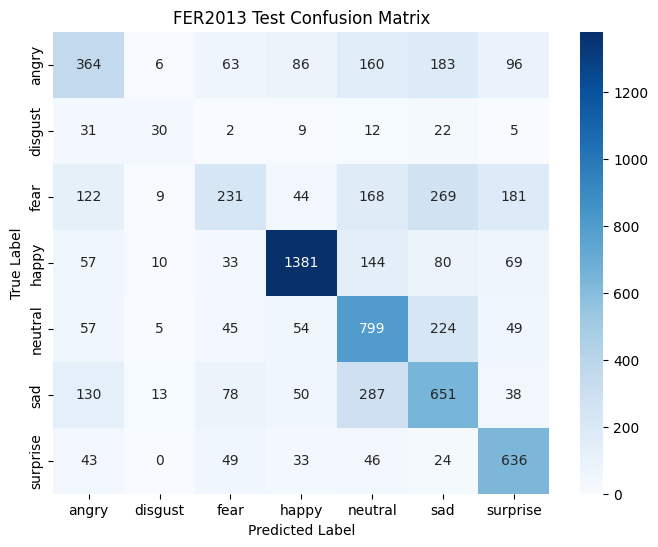

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Test transforms ====
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # replicate channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# ==== Load test dataset ====
test_dir = os.path.join(extract_path, "test")
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==== Device ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Load model ====
model = timm.create_model(
    'vit_small_patch16_224',
    pretrained=False,
    num_classes=len(test_dataset.classes)
)
model.load_state_dict(torch.load("vit_fer2013.pth", map_location=device))
model = model.to(device)
model.eval()

# ==== Criterion ====
criterion = torch.nn.CrossEntropyLoss()

# ==== Evaluation ====
all_labels = []
all_preds = []
test_loss = 0.0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# ==== Metrics ====
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# ==== Confusion Matrix ====
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('FER2013 Test Confusion Matrix')
plt.show()